## Objective

The dataset at hand comprises patient diagnosis information upon their departure from the hospital. However, this dataset underestimates the true number of patients admitted on any given day, as some might still be in the hospital at the time of data collection. To address this issue, our aim is to implement a "nowcasting" procedure, which aims at estimating the correct number of admitted patients, number of deaths and number of critical cases.

## Approach

To achieve our objective, we have outlined the following steps:

1. **Data Collection**: We have access to data regarding patient diagnosis upon leaving the hospital. However, we acknowledge that this data likely underrepresents the actual number of admissions due to patients still in the hospital at the time of data collection.

2. **Objective**: Our primary goal is to correct this underestimation by using a nowcasting model to estimate the true number of patients admitted.

3. **Gap Calculation**: we will calculate the "gap" between the received data (which is an underestimate) and the actual number of admitted patients across time. This gap represents the difference between the real number of admitted patients and the number based on exit diagnostics.

4. **Estimate of missing fractions**: Assuming that the distribution of patients stays duration is constant over time, we will infer the fraction of "missing" patients (see below for details). This will provide an idea of the necessary correction for each week.

5. **Simulated Data**: As we currently lack sufficient real data, we will generate synthetic data using a stochastic (random) process to validate the approach. We assume a constant distribution of patient stays duration.

In practice, to test our methodology, we will simulate data for the year 2022. To begin with, we will calculate the mean and variance of our dataset. Initially, we will generate data for COVID-19 patients aged 65 and older with a stay of 5 days or more, corresponding to a dataset with substantial information.



We denote : 
- $N_t$ the **true** number of patients entering the hospital during week $t$.  
- $N_t^{t+j}$ the number of patients entering the hospital at time t, as recorded at time $t+j$. We have $N_t^{+\infty} = N_t$. In practice, we will consider that  $N_t^{t + 12} = N_t$
- $\alpha_j$ the fraction of patients entered at week $t$ who will be added to the record from week $j-1$ to $j$.


Next, we will define 12 fake alphas drawn from an exponential distribution, which we will then normalize to ensure they sum up to 1.

Subsequently, we will create a table of fake data corresponding to admissions and discharges while incorporating all 2022 dataset updates based on the corresponding $\alpha$ values.
To illustrate, consider the initial update for the first week of 2022, which equates to $\alpha_1 N_1$. Here, $N_1$ represents the actual number of patients admitted during the first week. Moving forward, the second update in this database corresponds to $(\alpha_1 + \alpha_2) N_1$ and $\alpha_1 N_2$, and so forth. This sequence continues up to the twelfth update, corresponding to the 12 unique alphas, so that $\sum_{k=1}^{12} \alpha_k = 1$, meaning that for all subsequent updates (after week 12), the value remains $N_1$.


### 1. Import libraries

In [346]:
import os
import pandas as pd
import re

from kedro.pipeline import *
from kedro.io import *
from kedro.runner import *

import pickle
import os

import numpy as np
import matplotlib.pyplot as plt
import random

### 2. Download & filtered dataset

We start with downloading the 2023 dataset, which serves as the foundation for simulating coherent synthetic data for the year 2022. For this illustrative example, we strategically filter this dataset to focus on COVID-19 patients aged 65 and older, with a required RSS duration of 5 days or more. This subset provides a rich dataset with substantial information. Once we have obtained the number of patients in this specific category, we calculate both the mean and variance of this dataset. These statistics serve as the foundation for our data simulation process, employing a stochastic process.

In [347]:
csv_file_path = r'C:\Users\jrubio\hcl_data\data\02_intermediate\table_I_final.csv'
df = pd.read_csv(csv_file_path)
df

,WEEK_LABEL,DIAGNOSIS_CATEGORY,AGE_CLASS,RSS_DURATION_CLASS,N_CASES,BASELINE_N_CASES,LOWER_CI_BASELINE_N_CASES,UPPER_CI_BASELINE_N_CASES,N_CASES_NOWCAST,N_CASES_SMOOTH
0,2023-01-02,COVID_19,65 years and older,5 days and more,42,27,16.815728,37.184272,42,42.000000
1,2023-01-09,COVID_19,65 years and older,5 days and more,31,27,16.815728,37.184272,31,36.498472
2,2023-01-16,COVID_19,65 years and older,5 days and more,23,27,16.815728,37.184272,23,31.996482
3,2023-01-23,COVID_19,65 years and older,5 days and more,25,27,16.815728,37.184272,25,30.245903
4,2023-01-30,COVID_19,65 years and older,5 days and more,16,27,16.815728,37.184272,16,27.393556
...,...,...,...,...,...,...,...,...,...,...
2623,2023-03-27,RSV,[50 - 65[ years,[2 - 5[ days,0,0,0.000000,0.000000,2,1.001481
2624,2023-04-03,RSV,[50 - 65[ years,[2 - 5[ days,0,0,0.000000,0.000000,3,1.155727
2625,2023-04-10,RSV,[50 - 65[ years,[2 - 5[ days,0,0,0.000000,0.000000,4,1.359623
2626,2023-04-17,RSV,[50 - 65[ years,[2 - 5[ days,0,0,0.000000,0.000000,6,1.670186


In [348]:
filtered_df = df[(df['DIAGNOSIS_CATEGORY'] == 'COVID_19') & (df['AGE_CLASS'] == '65 years and older') & (df['RSS_DURATION_CLASS'] == '5 days and more')]
filtered_df

,WEEK_LABEL,DIAGNOSIS_CATEGORY,AGE_CLASS,RSS_DURATION_CLASS,N_CASES,BASELINE_N_CASES,LOWER_CI_BASELINE_N_CASES,UPPER_CI_BASELINE_N_CASES,N_CASES_NOWCAST,N_CASES_SMOOTH
0,2023-01-02,COVID_19,65 years and older,5 days and more,42,27,16.815728,37.184272,42,42.000000
1,2023-01-09,COVID_19,65 years and older,5 days and more,31,27,16.815728,37.184272,31,36.498472
2,2023-01-16,COVID_19,65 years and older,5 days and more,23,27,16.815728,37.184272,23,31.996482
3,2023-01-23,COVID_19,65 years and older,5 days and more,25,27,16.815728,37.184272,25,30.245903
4,2023-01-30,COVID_19,65 years and older,5 days and more,16,27,16.815728,37.184272,16,27.393556
5,2023-02-06,COVID_19,65 years and older,5 days and more,14,19,10.456715,27.543285,14,25.158195
6,2023-02-13,COVID_19,65 years and older,5 days and more,17,19,10.456715,27.543285,17,23.990795
7,2023-02-20,COVID_19,65 years and older,5 days and more,24,19,10.456715,27.543285,24,23.991948
8,2023-02-27,COVID_19,65 years and older,5 days and more,20,19,10.456715,27.543285,20,23.547412
9,2023-03-06,COVID_19,65 years and older,5 days and more,31,31,20.087382,41.912618,31,24.294535


### 3. Simulate data

The objective now is to generate synthetic patient admission data, by sampling from a Gaussian process whose mean match the mean of the dataset, and whith a squared exponential kernel with arbitrary lengthscale (chosen to ensure smooth enough trajectory). 

For the upcoming phases of our study, we will select one of the five generated curves to serve as the basis for constructing our synthetic dataset for the year 2022. We will suppose that this curve will represent the reality. 

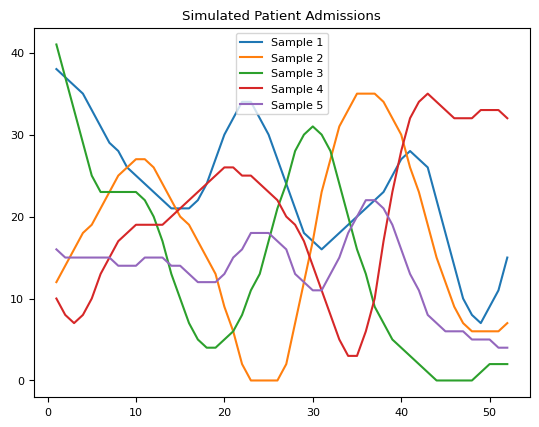

In [349]:
# Set a random seed for reproducibility
random.seed(123)

# Determine the maximum value of N_CASES from the DataFrame (substitute 'N_CASES' with the actual column name)
max_N_CASES = filtered_df['N_CASES'].max()

# Define the number of time points
num_time_points = 52

# Define the available data, typically historical patient admissions
# Replace this with your actual historical data if available
available_data = filtered_df['N_CASES']  # Extract the 'N_CASE' column from your DataFrame

# Calculate the mean based on the available data
def mean_func(x):
    # Utilize the available data to estimate the mean
    # In this example, it's a simple average of the available data
    return np.mean(available_data)

# Compute the covariance based on available data with an adjustable parameter, tau
def cov_func(x1, x2):
    tau = 5  # Adjust this value to control the smoothness
    return np.var(available_data) * np.exp(-0.5 * (x1 - x2) ** 2 / (tau ** 2))

# Generate the x values (time points)
x = np.linspace(1, num_time_points, num_time_points)

# Calculate the mean and covariance matrices based on available data
mean = np.array([mean_func(_) for _ in x])
cov = np.array([[cov_func(x1, x2) for x1 in x] for x2 in x])

# Generate samples from a multivariate normal distribution, constrained within the 0 to max_N_CASES range
samples = np.random.multivariate_normal(mean, cov, size=5)
samples = np.clip(samples, 0, max_N_CASES)  # Ensure values remain within the specified range

samples = samples.astype(int)

# Plot the samples
for i in range(5):
    plt.plot(x, samples[i], label=f'Sample {i + 1}')

# Set the title and legend
plt.title('Simulated Patient Admissions')
plt.legend()

# Display the plot
plt.show()

### 4. Create fake alphas


The goal now is to create a table that represents the data updates throughout the year 2022. To achieve this, we need to generate the $\alpha$.

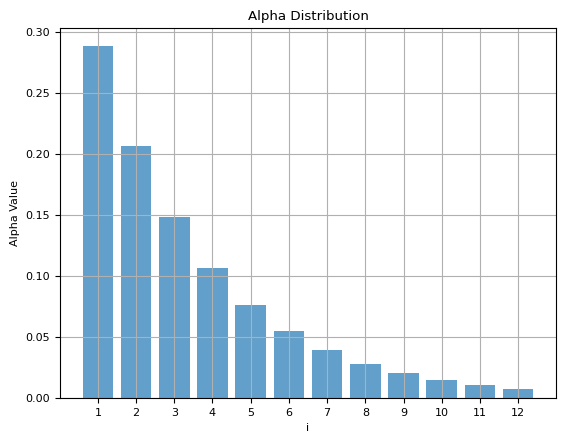

In [350]:
# Parameters for the exponential distribution
tau = 3  # You can adjust this parameter as needed

# Generate 12 alphas from the exponential distribution
i = np.arange(1, 13)
alphas = np.exp(-i / tau)

# Normalize the alphas so that their sum is equal to 1
alphas /= alphas.sum()

# Plot the distribution of alphas with explicit x-axis labels
plt.bar(i, alphas, align='center', alpha=0.7)
plt.xticks(i)  # Set x-axis ticks to be the same as i
plt.xlabel('i')
plt.ylabel('Alpha Value')
plt.title('Alpha Distribution')
plt.grid()

plt.show()

In [351]:
Truth_2022 = np.array(samples[0])
True_alphas = np.array(alphas)

In [352]:
Truth_2022 = np.array(Truth_2022)
True_alphas = np.array(True_alphas)

In [353]:
Data_2022 = np.zeros((52, 52))
for i in range(0, 53):
    for j in range(i):
        Data_2022[i-1, j] = np.sum(Truth_2022[j] * True_alphas[:min(i - j, 12)])
Data_2022_final = np.vstack((Truth_2022, Data_2022))

In [354]:
df = pd.DataFrame(Data_2022_final)

# Spécifiez l'emplacement du fichier CSV
chemin_fichier = "C:\\Users\\jrubio\\hcl_data\\data\\07_model_output\\Data_2022_final.csv"

# Enregistrez le DataFrame dans un fichier CSV
df.to_csv(chemin_fichier)

Once we have generated all our synthetic data, incorporating the lag between the real and observed data, we will infer the $\alpha$ back.

$\alpha_j$ is the fraction of patients entered at week $t$ who will be added to the record from week $j-1$ to $j$.
Let assume that we have received a series of $m$ updates to the data, an estimator of $\alpha_j$ is : 

$$\widehat{\alpha}_{j} = \frac{1}{m}\sum_{t=1}^{m} \dfrac{N_t^{t+j} - N_t^{t+j-1}}{N_t^{t+12}}$$


In [355]:
# Initialize an array to store the estimated alpha values
alphas_estimates = np.zeros(12)

# Iterate through 12 time steps to calculate alpha estimates
for k in range(12):
    
    # Extract the k-th diagonal elements from the "Data_2022" array
    diagonal = Data_2022[np.arange(k, 52), np.arange(0, 52 - k)]
    
    # Create a boolean mask to exclude zero values from "Truth_2022"
    mask = Truth_2022[0:len(Truth_2022) - k] != 0
    
    # Calculate the alpha_k estimate by considering only non-zero samples
    alpha_k_estimate = np.mean(diagonal[mask] / Truth_2022[0:len(Truth_2022) - k][mask])
    
    # Adjust the alpha estimate by subtracting the effects of previous alphas
    for j in range(k):
        alpha_k_estimate -= alphas_estimates[j]
    
    # Store the alpha_k estimate in the "alphas_estimates" array
    alphas_estimates[k] = alpha_k_estimate

# The 12 alpha values have been calculated and stored in "alphas_estimates"

# Display the calculated alpha values
for k, alpha in enumerate(alphas_estimates):
    print(f"Estimated alpha_{k + 1} = {alpha}")

Estimated alpha_1 = 0.2887574669166822
Estimated alpha_2 = 0.2069037662077779
Estimated alpha_3 = 0.14825302676351204
Estimated alpha_4 = 0.1062279355633905
Estimated alpha_5 = 0.076115641888784
Estimated alpha_6 = 0.05453924063773541
Estimated alpha_7 = 0.039079073571855805
Estimated alpha_8 = 0.028001379802451876
Estimated alpha_9 = 0.020063865367725198
Estimated alpha_10 = 0.01437638774711214
Estimated alpha_11 = 0.010301131953754927
Estimated alpha_12 = 0.007381083579217795


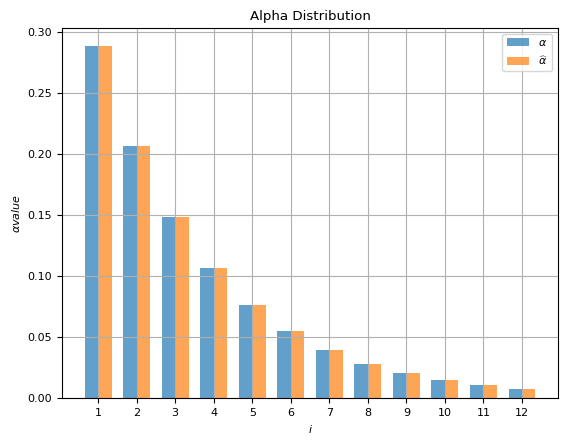

In [356]:
i = np.arange(1, len(True_alphas) + 1)  # Create a vector for the x-axis

# Bar width for better spacing
bar_width = 0.35

# Create the bar chart
plt.bar(i - bar_width/2, True_alphas, bar_width, alpha=0.7, label= r'$\alpha$')
plt.bar(i + bar_width/2, alphas_estimates, bar_width, alpha=0.7, label= r'$\widehat{\alpha}$')

# Axis labels and chart title
plt.xticks(i)
plt.xlabel(r'$i$')
plt.ylabel(r'$\alpha  value$')
plt.title('Alpha Distribution')
plt.legend()  # Display the legend with series labels
plt.grid()

# Show the chart
plt.show()


# More realistic, stochastic modelling

We assume that : 
$N_T^{t+j} = N_t^{t+j-1} + U$
Where $U \sim B(N_t- N_t^{t+j-1}, \alpha_j)$.
Except for the last (12th) update, which is deterministic : $N_T^{t+12} = N_t - N_t^{t+11}$ 


In [357]:
import numpy as np

# Create a 52x52 matrix
Data_2022_stochastic = np.zeros((52, 52))

# Iterate over the weeks
for t in range(52):
    # N_t represents the value of N for week t from Truth_2022
    N_t = Truth_2022[t]

    # Deterministic update for week t+1
    U = np.random.binomial(N_t, True_alphas[0])
    Data_2022_stochastic[t, t] = U

    # Stochastic updates for weeks t+2 to t+12
    for j in range(1, 12):
        if t + j < 52:
            if N_t != Data_2022_stochastic[t+j-1, t]:
                # Calculate b based on True_alphas
                b = True_alphas[j] * N_t / (N_t - sum(True_alphas[0:j]) * N_t)
                U = np.random.binomial(N_t - Data_2022_stochastic[t+j-1, t], b)
            else:
                U = 0
            Data_2022_stochastic[t+j, t] = Data_2022_stochastic[t+j-1, t] + U

# Stack Truth_2022 and the Data_2022_stochastic to create Data_2022_stochastic_final
Data_2022_stochastic_final = np.vstack((Truth_2022, Data_2022_stochastic))


In [358]:
# Initialize an array to store the estimated alpha values
alphas_estimates = np.zeros(12)

# Iterate through 12 time steps to calculate alpha estimates
for k in range(12):
    
    # Extract the k-th diagonal elements from the "Data_2022_stochastic" array
    diagonal = Data_2022_stochastic[np.arange(k, 52), np.arange(0, 52 - k)]
    
    # Create a boolean mask to exclude zero values from "samples"
    mask = Truth_2022[0:len(Truth_2022) - k] != 0
    
    # Calculate the alpha_k estimate by considering only non-zero samples
    alpha_k_estimate = np.mean(diagonal[mask] / Truth_2022[0:len(Truth_2022) - k][mask])
    
    # Adjust the alpha estimate by subtracting the effects of previous alphas
    for j in range(k):
        alpha_k_estimate -= alphas_estimates[j]
    
    # Store the alpha_k estimate in the "alphas_estimates" array
    alphas_estimates[k] = alpha_k_estimate

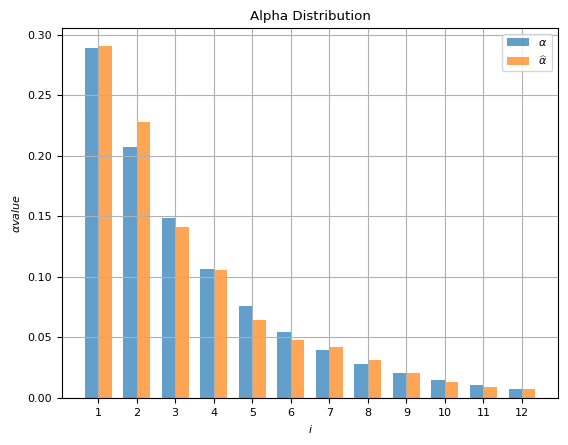

In [359]:
i = np.arange(1, len(True_alphas) + 1)  # Create a vector for the x-axis

# Bar width for better spacing
bar_width = 0.35

# Create the bar chart
plt.bar(i - bar_width/2, True_alphas, bar_width, alpha=0.7, label= r'$\alpha$')
plt.bar(i + bar_width/2, alphas_estimates, bar_width, alpha=0.7, label= r'$\widehat{\alpha}$')

# Axis labels and chart title
plt.xticks(i)
plt.xlabel(r'$i$')
plt.ylabel(r'$\alpha  value$')
plt.title('Alpha Distribution')
plt.legend()  # Display the legend with series labels
plt.grid()

# Show the chart
plt.show()


# Creation of new Data 2023

First, we generated synthetic data for 2022, which we consider as ground truth (Truth_2022). This data represents the real number of patients admitted to the hospital each week (N_weeks x 1).

Next, we created the true alphas (True_alphas), which represent the fraction of patients entered in week 't' that will be added to the record from week 'j-1' to 'j'.

Then, we created a DataFrame that includes all the weekly updates for the year, but with biased data (Data_2022). These biased data were generated by combining True_alphas with Truth_2022.

Based on Data_2022, we estimated True_alphas, and these estimates are referred to as alphas_estimates.

Now, let's assume we receive data for 2023 in the form of Data_2023. To reconstruct the true data for 2023 (Truth_2023), we generate it by combining True_alphas with Truth_2023 in the same manner as we did for Data_2022. We do not know Truth_2023 but aim to reconstruct it.

To achieve this, we combine Estimated_alphas with Data_2023 to "de-bias" Data_2023, making the assumption that the alphas remain constant over time.


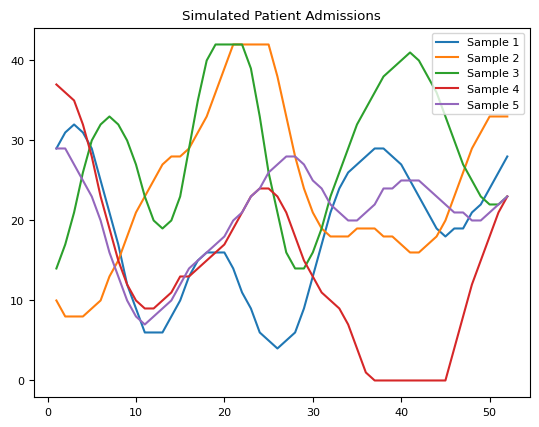

In [360]:
# Set a random seed for reproducibility
random.seed(123)

# Determine the maximum value of N_CASES from the DataFrame (substitute 'N_CASES' with the actual column name)
max_N_CASES = filtered_df['N_CASES'].max()

# Define the number of time points
num_time_points = 52

# Define the available data, typically historical patient admissions
# Replace this with your actual historical data if available
available_data = filtered_df['N_CASES']  # Extract the 'N_CASE' column from your DataFrame

# Calculate the mean based on the available data
def mean_func(x):
    # Utilize the available data to estimate the mean
    # In this example, it's a simple average of the available data
    return np.mean(available_data)

# Compute the covariance based on available data with an adjustable parameter, tau
def cov_func(x1, x2):
    tau = 5  # Adjust this value to control the smoothness
    return np.var(available_data) * np.exp(-0.5 * (x1 - x2) ** 2 / (tau ** 2))

# Generate the x values (time points)
x = np.linspace(1, num_time_points, num_time_points)

# Calculate the mean and covariance matrices based on available data
mean = np.array([mean_func(_) for _ in x])
cov = np.array([[cov_func(x1, x2) for x1 in x] for x2 in x])

# Generate samples from a multivariate normal distribution, constrained within the 0 to max_N_CASES range
samples = np.random.multivariate_normal(mean, cov, size=5)
samples = np.clip(samples, 0, max_N_CASES)  # Ensure values remain within the specified range

samples = samples.astype(int)

# Plot the samples
for i in range(5):
    plt.plot(x, samples[i], label=f'Sample {i + 1}')

# Set the title and legend
plt.title('Simulated Patient Admissions')
plt.legend()

# Display the plot
plt.show()

Truth_2023 = np.array(samples[0])
Truth_2023 = np.array(Truth_2023)

In [361]:
import numpy as np

# Create a 52x52 matrix
data_2023 = np.zeros((52, 52))

# Iterate over the weeks
for t in range(52):
    # N_t represents the value of N for week t from Truth_2022
    N_t = Truth_2023[t]

    # Deterministic update for week t+1
    U = np.random.binomial(N_t, True_alphas[0])
    data_2023[t, t] = U

    # Stochastic updates for weeks t+2 to t+12
    for j in range(1, 12):
        if t + j < 52:
            if N_t != data_2023[t+j-1, t]:
                # Calculate b based on True_alphas
                b = True_alphas[j] * N_t / (N_t - sum(True_alphas[0:j]) * N_t)
                U = np.random.binomial(N_t - data_2023[t+j-1, t], b)
            else:
                U = 0
            data_2023[t+j, t] = data_2023[t+j-1, t] + U

# Stack Truth_2022 and the Data_2022_stochastic to create Data_2022_stochastic_final
data_2023_final = np.vstack((Truth_2023, data_2023))


In [362]:
df = pd.DataFrame(data_2023_final)
chemin_fichier = "C:\\Users\\jrubio\\hcl_data\\data\\07_model_output\\data_2023_final.csv"
df.to_csv(chemin_fichier)

In [363]:
data_2023_unbiased = np.zeros_like(data_2023)

# Itération sur les semaines
for t in range(52):
    for j in range(t, 52):
        denominator = sum(alphas[:min(j - t + 1, 12)])
        data_2023_unbiased[j, t] = data_2023[j, t] / denominator
data_2023_unbiased_final = np.vstack((Truth_2023, data_2023_unbiased))


In [364]:
df = pd.DataFrame(data_2023_unbiased_final)
chemin_fichier = "C:\\Users\\jrubio\\hcl_data\\data\\07_model_output\\data_2023_unbiased_final.csv"
df.to_csv(chemin_fichier)

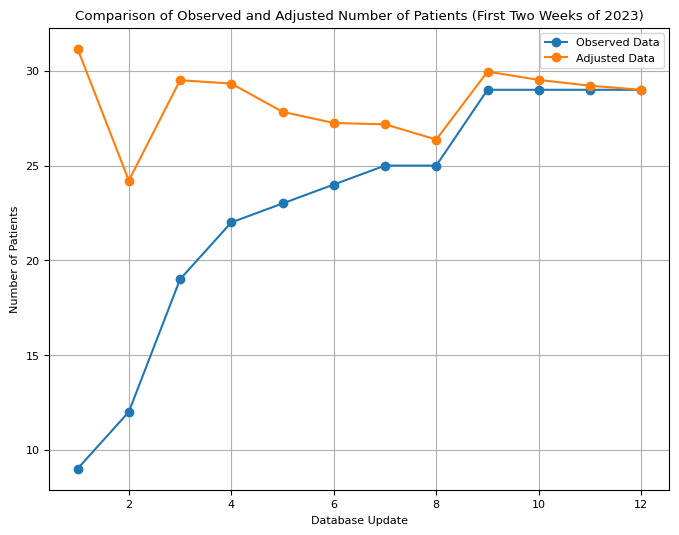

In [365]:
import matplotlib.pyplot as plt

# Select the first 12 values from the first column of data_2023 and data_2023_unbiased
data_2023_first_column = data_2023[:12, 0]
data_2023_unbiased_first_column = data_2023_unbiased[:12, 0]

# Create a list of updates (from 1 to 12)
updates = list(range(1, 13))

# Plot the data
plt.figure(figsize=(8, 6))
plt.plot(updates, data_2023_first_column, marker='o', label='Observed Data')
plt.plot(updates, data_2023_unbiased_first_column, marker='o', label='Adjusted Data')
plt.xlabel('Database Update')
plt.ylabel('Number of Patients')
plt.title('Comparison of Observed and Adjusted Number of Patients (First Two Weeks of 2023)')
plt.legend()
plt.grid(True)
plt.show()


In [366]:
# Initialize a list to store the first 12 values per column
first_12_values_per_column = []

# Iterate over the first 40 columns
for i in range(40):
    # Extract the first 12 values from the diagonal of data_2023_unbiased
    values = data_2023_unbiased[i:i+12, i]
    first_12_values_per_column.append(values)

# Suppose first_12_values_per_column contains the data as described earlier

# Initialize a list to store adjusted data
adjusted_data = []

# Iterate over the first 40 columns
for i, column_values in enumerate(first_12_values_per_column):
    # Calculate the absolute difference between the column values and Truth_2023 values
    adjusted_column = abs(column_values - Truth_2023[i]) / max(Truth_2023[i], 1)
    adjusted_data.append(adjusted_column)


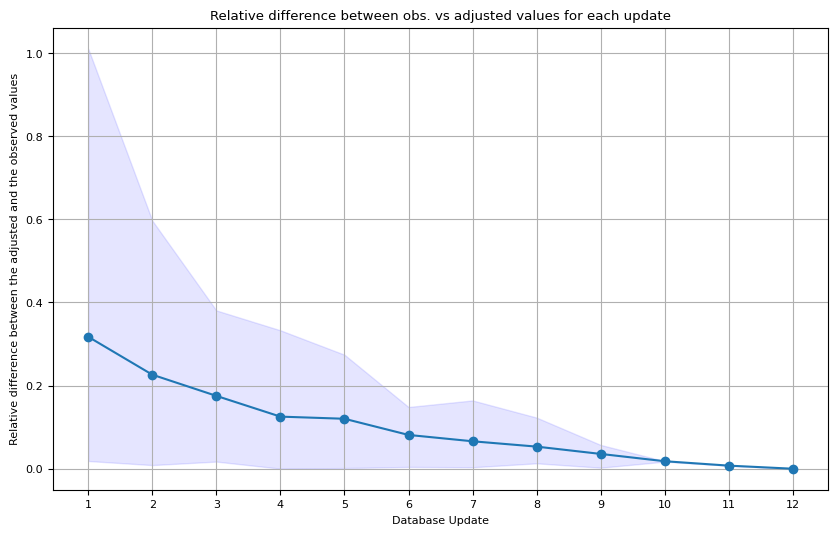

In [368]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming 'adjusted_data' contains the adjusted data as described earlier
plt.rc('font', size=8)  # Set the font size

# Create a figure
plt.figure(figsize=(10, 6))

# Calculate the measure of relative difference for one week (let's use the first week as an example)
relative_difference = np.array(adjusted_data).mean(axis=0)  # Calculate the mean relative difference

# Define the x-axis values from 1 to 12
x_values = np.arange(1, 13)

# Compute the lower and upper quantiles of the posterior distribution
confidence_level = 0.95

lower_quantile = (1 - confidence_level) / 2
upper_quantile = 1 - lower_quantile

# Use np.percentile to calculate credible intervals
credible_intervals = np.percentile(adjusted_data, q=[lower_quantile * 100, upper_quantile * 100], axis=0)

# Plot the relative difference for each column (week) with x-axis values
plt.plot(x_values, relative_difference, marker='o')
# Plot the credible intervals
plt.fill_between(x_values, credible_intervals[0], credible_intervals[1], alpha=0.1, color='blue')

# Set x-ticks with a step of 1
plt.xticks(x_values)

# Add legends, title, axis labels, etc.
plt.title('Relative difference between obs. vs adjusted values for each update')
plt.xlabel('Database Update')
plt.ylabel('Relative difference between the adjusted and the observed values')

# Display the plot
plt.grid(True)
plt.show()
